In [1]:
import os
from graphgym.custom_graphgym.loader.protein import ProteinDataset
import matplotlib.pyplot as plt

In [2]:
os.chdir('/Users/cgu3/Documents/Grape-Pi')

In [3]:
dataset = ProteinDataset("data/single", numeric_columns=['protein_probability'], label_column='hard_label', rebuild=True)
# dataset = ProteinDataset("data/yeast-ORBI", numeric_columns=['protein_probability'], label_column=None, rebuild=True)
# dataset = ProteinDataset("data/human-ORBI", numeric_columns=['protein_probability'], label_column='label', rebuild=True)

Rebuilding...
Done!


In [4]:
import copy
import time
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import SAGEConv

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = dataset[0].to(device, 'x', 'y', 'train_mask', 'val_mask', 'test_mask')

In [5]:
import torchmetrics
from torchmetrics.classification import BinaryAUROC, BinaryAccuracy, BinaryF1Score

# 
approx_train_collection = torchmetrics.MetricCollection(
    BinaryAccuracy(),
    BinaryAUROC(),
    BinaryF1Score()
)

train_collection = torchmetrics.MetricCollection(
    BinaryAccuracy(),
    BinaryAUROC(),
    BinaryF1Score()
)

val_collection = torchmetrics.MetricCollection(
    BinaryAccuracy(),
    BinaryAUROC(),
    BinaryF1Score()
)

test_collection = torchmetrics.MetricCollection(
    BinaryAccuracy(),
    BinaryAUROC(),
    BinaryF1Score()
)

approx_train_tracker = torchmetrics.wrappers.MetricTracker(approx_train_collection)
train_tracker = torchmetrics.wrappers.MetricTracker(train_collection)
val_tracker = torchmetrics.wrappers.MetricTracker(val_collection)
test_tracker = torchmetrics.wrappers.MetricTracker(test_collection)
    

In [6]:
from torch_geometric.seed import seed_everything
seed_everything(42)

kwargs = {'batch_size': 512, 'num_workers': 2, 'persistent_workers': True}
train_loader = NeighborLoader(data, input_nodes=data.train_mask,
                              num_neighbors=[50], shuffle=True, **kwargs)

subgraph_loader = NeighborLoader(copy.copy(data), input_nodes=None,
                                 num_neighbors=[-1], shuffle=False, **kwargs)

# No need to maintain these features during evaluation:
del subgraph_loader.data.x, subgraph_loader.data.y
# Add global node index information.
subgraph_loader.data.num_nodes = data.num_nodes
subgraph_loader.data.n_id = torch.arange(data.num_nodes)


class SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        # a single conv layer and a single linear layer
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        self.lin1 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            x = x.relu_()
            x = self.lin1(x)
        return x

    @torch.no_grad()
    def inference(self, x_all, subgraph_loader):
        # pbar = tqdm(total=len(subgraph_loader.dataset) * len(self.convs))
        # pbar.set_description('Evaluating')

        # Compute representations of nodes layer by layer, using *all*
        # available edges. This leads to faster computation in contrast to
        # immediately computing the final representations of each batch:
        for i, conv in enumerate(self.convs):
            xs = []
            for batch in subgraph_loader:
                x = x_all[batch.n_id.to(x_all.device)].to(device)
                x = conv(x, batch.edge_index.to(device))
                x = x.relu_()
                x = self.lin1(x)
                xs.append(x[:batch.batch_size].cpu())
                # pbar.update(batch.batch_size)
            x_all = torch.cat(xs, dim=0)
        # pbar.close()
        return x_all


model = SAGE(dataset.num_features, 10, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(epoch):
    model.train()

    pbar = tqdm(total=int(len(train_loader.dataset)))
    pbar.set_description(f'Epoch {epoch:02d}')
    
    total_loss = total_examples = 0
    approx_train_tracker.increment() # the start of a new epoch
    
    for batch in train_loader:
        optimizer.zero_grad()
        y = batch.y[:batch.batch_size]
        logits = model(batch.x, batch.edge_index.to(device))[:batch.batch_size].squeeze(-1)
        
        # create hard label only for confidence proteins and used for binary classification evaluation
        y_pred_prob = torch.nn.functional.sigmoid(logits)
        # y_hard = torch.where(y > 0.99, 1, 
        #                      torch.where(y < 0.5, 0, -1))
        # binary_mask = (y_hard != -1).bool()

        
        loss = F.binary_cross_entropy_with_logits(logits.squeeze(-1), y)
        loss.backward()
        optimizer.step()

        total_loss += float(loss) * batch.batch_size
        approx_train_tracker.update(y_pred_prob, y)
        total_examples += batch.batch_size
        pbar.update(batch.batch_size)
    pbar.close()

    return total_loss / total_examples



@torch.no_grad()
def test():
    model.eval()
    logits = model.inference(data.x, subgraph_loader).squeeze(-1)
    y_pred_prob = torch.nn.functional.sigmoid(logits)
 
    loss = []
    train_tracker.update(y_pred_prob[data.train_mask], data.y[data.train_mask])
    val_tracker.update(y_pred_prob[data.val_mask], data.y[data.val_mask])
    test_tracker.update(y_pred_prob[data.test_mask], data.y[data.test_mask])
    # train_tracker.update(y_pred_prob[data.train_mask & binary_mask], y_hard[data.train_mask & binary_mask])
    # val_tracker.update(y_pred_prob[data.val_mask & binary_mask], y_hard[data.val_mask & binary_mask])
    # test_tracker.update(y_pred_prob[data.test_mask & binary_mask], y_hard[data.test_mask & binary_mask])
    
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        loss.append(F.binary_cross_entropy_with_logits(logits[mask], data.y[mask]))
    
    return loss

In [7]:
approx_train_losses = []
train_losses = []
val_losses = []
test_losses = []

times = []
for epoch in range(1, 30):
    start = time.time()
    
    # Evaluation before first training epoch starts
    train_tracker.increment()
    val_tracker.increment()
    test_tracker.increment()

    train_loss, val_loss, test_loss = test()
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    
    train_metrics = train_tracker.compute()
    val_metrics = val_tracker.compute()
    test_metrics = test_tracker.compute()
    
    print(f'Epoch: {epoch:02d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
          f'Test Loss: {test_loss:.4f}')
    print(f'Epoch: {epoch:02d}, Train Acc: {train_metrics["BinaryAccuracy"]:.4f}, Val Acc: {val_metrics["BinaryAccuracy"]:.4f}, '
          f'Test Acc: {test_metrics["BinaryAccuracy"]:.4f}')
    print(f'Epoch: {epoch:02d}, Train AUC: {train_metrics["BinaryAUROC"]:.4f}, Val AUC: {val_metrics["BinaryAUROC"]:.4f}, '
          f'Test AUC: {test_metrics["BinaryAUROC"]:.4f}')
    print(f'Epoch: {epoch:02d}, Train F1: {train_metrics["BinaryF1Score"]:.4f}, Val F1: {val_metrics["BinaryF1Score"]:.4f}, '
            f'Test F1: {test_metrics["BinaryF1Score"]:.4f}')
    
    approx_train_loss = train(epoch)
    approx_train_losses.append(approx_train_loss)
    approx_train_metrics = approx_train_tracker.compute()
    print(f'Epoch {epoch:02d}, Approx train loss: {approx_train_loss:.4f}, Approx. Train Acc: {approx_train_metrics["BinaryAccuracy"]:.4f},'
          f'Approx. Train AUC: {approx_train_metrics["BinaryAUROC"]:.4f}, Approx. Train F1: {approx_train_metrics["BinaryF1Score"]:.4f}')
    
    
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

Epoch: 01, Train Loss: 0.7571, Val Loss: 0.7570, Test Loss: 0.7542
Epoch: 01, Train Acc: 0.3200, Val Acc: 0.3092, Test Acc: 0.3183
Epoch: 01, Train AUC: 0.0453, Val AUC: 0.0559, Test AUC: 0.0356
Epoch: 01, Train F1: 0.4847, Val F1: 0.4724, Test F1: 0.4829


Epoch 01: 100%|██████████| 4425/4425 [00:01<00:00, 2771.97it/s]


Epoch 01, Approx train loss: 0.7536, Approx. Train Acc: 0.4221,Approx. Train AUC: 0.0461, Approx. Train F1: 0.5935
Epoch: 02, Train Loss: 0.7492, Val Loss: 0.7495, Test Loss: 0.7462
Epoch: 02, Train Acc: 0.4606, Val Acc: 0.4503, Test Acc: 0.4756
Epoch: 02, Train AUC: 0.0449, Val AUC: 0.0555, Test AUC: 0.0361
Epoch: 02, Train F1: 0.6307, Val F1: 0.6209, Test F1: 0.6446


Epoch 02: 100%|██████████| 4425/4425 [00:00<00:00, 81297.07it/s]


Epoch 02, Approx train loss: 0.7460, Approx. Train Acc: 0.4606,Approx. Train AUC: 0.0467, Approx. Train F1: 0.6307
Epoch: 03, Train Loss: 0.7418, Val Loss: 0.7426, Test Loss: 0.7389
Epoch: 03, Train Acc: 0.4606, Val Acc: 0.4503, Test Acc: 0.4756
Epoch: 03, Train AUC: 0.0444, Val AUC: 0.0553, Test AUC: 0.0358
Epoch: 03, Train F1: 0.6307, Val F1: 0.6209, Test F1: 0.6446


Epoch 03: 100%|██████████| 4425/4425 [00:00<00:00, 82834.41it/s]


Epoch 03, Approx train loss: 0.7389, Approx. Train Acc: 0.4606,Approx. Train AUC: 0.0461, Approx. Train F1: 0.6307
Epoch: 04, Train Loss: 0.7349, Val Loss: 0.7361, Test Loss: 0.7320
Epoch: 04, Train Acc: 0.4606, Val Acc: 0.4503, Test Acc: 0.4756
Epoch: 04, Train AUC: 0.0437, Val AUC: 0.0556, Test AUC: 0.0352
Epoch: 04, Train F1: 0.6307, Val F1: 0.6209, Test F1: 0.6446


Epoch 04: 100%|██████████| 4425/4425 [00:00<00:00, 82178.62it/s]


Epoch 04, Approx train loss: 0.7322, Approx. Train Acc: 0.4606,Approx. Train AUC: 0.0446, Approx. Train F1: 0.6307
Epoch: 05, Train Loss: 0.7284, Val Loss: 0.7300, Test Loss: 0.7255
Epoch: 05, Train Acc: 0.4606, Val Acc: 0.4503, Test Acc: 0.4756
Epoch: 05, Train AUC: 0.0434, Val AUC: 0.0566, Test AUC: 0.0350
Epoch: 05, Train F1: 0.6307, Val F1: 0.6209, Test F1: 0.6446


Epoch 05: 100%|██████████| 4425/4425 [00:00<00:00, 82141.89it/s]


Epoch 05, Approx train loss: 0.7258, Approx. Train Acc: 0.4606,Approx. Train AUC: 0.0508, Approx. Train F1: 0.6307
Epoch: 06, Train Loss: 0.7223, Val Loss: 0.7241, Test Loss: 0.7195
Epoch: 06, Train Acc: 0.4606, Val Acc: 0.4503, Test Acc: 0.4756
Epoch: 06, Train AUC: 0.0637, Val AUC: 0.0754, Test AUC: 0.0500
Epoch: 06, Train F1: 0.6307, Val F1: 0.6209, Test F1: 0.6446


Epoch 06: 100%|██████████| 4425/4425 [00:00<00:00, 80667.40it/s]

Epoch 06, Approx train loss: 0.7197, Approx. Train Acc: 0.4606,Approx. Train AUC: 0.0827, Approx. Train F1: 0.6307


Epoch: 07, Train Loss: 0.7164, Val Loss: 0.7185, Test Loss: 0.7138
Epoch: 07, Train Acc: 0.4606, Val Acc: 0.4503, Test Acc: 0.4756
Epoch: 07, Train AUC: 0.1002, Val AUC: 0.1127, Test AUC: 0.0868
Epoch: 07, Train F1: 0.6307, Val F1: 0.6209, Test F1: 0.6446


Epoch 07: 100%|██████████| 4425/4425 [00:00<00:00, 82793.39it/s]


Epoch 07, Approx train loss: 0.7140, Approx. Train Acc: 0.4606,Approx. Train AUC: 0.1439, Approx. Train F1: 0.6307
Epoch: 08, Train Loss: 0.7107, Val Loss: 0.7130, Test Loss: 0.7083
Epoch: 08, Train Acc: 0.4606, Val Acc: 0.4503, Test Acc: 0.4756
Epoch: 08, Train AUC: 0.2915, Val AUC: 0.2776, Test AUC: 0.2454
Epoch: 08, Train F1: 0.6307, Val F1: 0.6209, Test F1: 0.6446


Epoch 08: 100%|██████████| 4425/4425 [00:00<00:00, 80347.87it/s]

Epoch 08, Approx train loss: 0.7084, Approx. Train Acc: 0.4606,Approx. Train AUC: 0.4154, Approx. Train F1: 0.6307


Epoch: 09, Train Loss: 0.7052, Val Loss: 0.7077, Test Loss: 0.7029
Epoch: 09, Train Acc: 0.4606, Val Acc: 0.4503, Test Acc: 0.4756
Epoch: 09, Train AUC: 0.5565, Val AUC: 0.5408, Test AUC: 0.5151
Epoch: 09, Train F1: 0.6307, Val F1: 0.6209, Test F1: 0.6446


Epoch 09: 100%|██████████| 4425/4425 [00:00<00:00, 80293.64it/s]


Epoch 09, Approx train loss: 0.7029, Approx. Train Acc: 0.4606,Approx. Train AUC: 0.6534, Approx. Train F1: 0.6307
Epoch: 10, Train Loss: 0.6996, Val Loss: 0.7025, Test Loss: 0.6976
Epoch: 10, Train Acc: 0.4606, Val Acc: 0.4503, Test Acc: 0.4756
Epoch: 10, Train AUC: 0.8051, Val AUC: 0.7952, Test AUC: 0.7675
Epoch: 10, Train F1: 0.6307, Val F1: 0.6209, Test F1: 0.6446


Epoch 10: 100%|██████████| 4425/4425 [00:00<00:00, 82507.05it/s]

Epoch 10, Approx train loss: 0.6974, Approx. Train Acc: 0.4606,Approx. Train AUC: 0.8216, Approx. Train F1: 0.6307
Epoch: 11, Train Loss: 0.6941, Val Loss: 0.6972, Test Loss: 0.6923
Epoch: 11, Train Acc: 0.4606, Val Acc: 0.4503, Test Acc: 0.4756
Epoch: 11, Train AUC: 0.8361, Val AUC: 0.8245, Test AUC: 0.8066
Epoch: 11, Train F1: 0.6307, Val F1: 0.6209, Test F1: 0.6446



Epoch 11: 100%|██████████| 4425/4425 [00:00<00:00, 82140.80it/s]


Epoch 11, Approx train loss: 0.6919, Approx. Train Acc: 0.4606,Approx. Train AUC: 0.8413, Approx. Train F1: 0.6307
Epoch: 12, Train Loss: 0.6886, Val Loss: 0.6919, Test Loss: 0.6870
Epoch: 12, Train Acc: 0.4606, Val Acc: 0.4503, Test Acc: 0.4756
Epoch: 12, Train AUC: 0.8488, Val AUC: 0.8386, Test AUC: 0.8207
Epoch: 12, Train F1: 0.6307, Val F1: 0.6209, Test F1: 0.6446


Epoch 12: 100%|██████████| 4425/4425 [00:00<00:00, 81948.94it/s]

Epoch 12, Approx train loss: 0.6863, Approx. Train Acc: 0.4606,Approx. Train AUC: 0.8534, Approx. Train F1: 0.6307


Epoch: 13, Train Loss: 0.6830, Val Loss: 0.6866, Test Loss: 0.6817
Epoch: 13, Train Acc: 0.4606, Val Acc: 0.4503, Test Acc: 0.4756
Epoch: 13, Train AUC: 0.8577, Val AUC: 0.8493, Test AUC: 0.8274
Epoch: 13, Train F1: 0.6307, Val F1: 0.6209, Test F1: 0.6446


Epoch 13: 100%|██████████| 4425/4425 [00:00<00:00, 80903.00it/s]


Epoch 13, Approx train loss: 0.6806, Approx. Train Acc: 0.4606,Approx. Train AUC: 0.8618, Approx. Train F1: 0.6307
Epoch: 14, Train Loss: 0.6772, Val Loss: 0.6811, Test Loss: 0.6762
Epoch: 14, Train Acc: 0.4606, Val Acc: 0.4503, Test Acc: 0.4756
Epoch: 14, Train AUC: 0.8631, Val AUC: 0.8538, Test AUC: 0.8386
Epoch: 14, Train F1: 0.6307, Val F1: 0.6209, Test F1: 0.6446


Epoch 14: 100%|██████████| 4425/4425 [00:00<00:00, 81075.11it/s]


Epoch 14, Approx train loss: 0.6748, Approx. Train Acc: 0.4606,Approx. Train AUC: 0.8655, Approx. Train F1: 0.6307
Epoch: 15, Train Loss: 0.6712, Val Loss: 0.6754, Test Loss: 0.6706
Epoch: 15, Train Acc: 0.4606, Val Acc: 0.4503, Test Acc: 0.4756
Epoch: 15, Train AUC: 0.8667, Val AUC: 0.8557, Test AUC: 0.8424
Epoch: 15, Train F1: 0.6307, Val F1: 0.6209, Test F1: 0.6446


Epoch 15: 100%|██████████| 4425/4425 [00:00<00:00, 80155.97it/s]


Epoch 15, Approx train loss: 0.6688, Approx. Train Acc: 0.4606,Approx. Train AUC: 0.8680, Approx. Train F1: 0.6307
Epoch: 16, Train Loss: 0.6651, Val Loss: 0.6695, Test Loss: 0.6647
Epoch: 16, Train Acc: 0.4606, Val Acc: 0.4503, Test Acc: 0.4756
Epoch: 16, Train AUC: 0.8698, Val AUC: 0.8610, Test AUC: 0.8446
Epoch: 16, Train F1: 0.6307, Val F1: 0.6209, Test F1: 0.6446


Epoch 16: 100%|██████████| 4425/4425 [00:00<00:00, 82515.48it/s]


Epoch 16, Approx train loss: 0.6625, Approx. Train Acc: 0.4599,Approx. Train AUC: 0.8718, Approx. Train F1: 0.6289
Epoch: 17, Train Loss: 0.6587, Val Loss: 0.6634, Test Loss: 0.6586
Epoch: 17, Train Acc: 0.4610, Val Acc: 0.4467, Test Acc: 0.4756
Epoch: 17, Train AUC: 0.8731, Val AUC: 0.8629, Test AUC: 0.8474
Epoch: 17, Train F1: 0.6278, Val F1: 0.6156, Test F1: 0.6420


Epoch 17: 100%|██████████| 4425/4425 [00:00<00:00, 83220.69it/s]


Epoch 17, Approx train loss: 0.6560, Approx. Train Acc: 0.4660,Approx. Train AUC: 0.8741, Approx. Train F1: 0.6227
Epoch: 18, Train Loss: 0.6520, Val Loss: 0.6570, Test Loss: 0.6522
Epoch: 18, Train Acc: 0.4793, Val Acc: 0.4503, Test Acc: 0.4665
Epoch: 18, Train AUC: 0.8755, Val AUC: 0.8635, Test AUC: 0.8514
Epoch: 18, Train F1: 0.6222, Val F1: 0.6021, Test F1: 0.6174


Epoch 18: 100%|██████████| 4425/4425 [00:00<00:00, 80009.46it/s]

Epoch 18, Approx train loss: 0.6492, Approx. Train Acc: 0.5012,Approx. Train AUC: 0.8775, Approx. Train F1: 0.6304


Epoch: 19, Train Loss: 0.6450, Val Loss: 0.6503, Test Loss: 0.6456
Epoch: 19, Train Acc: 0.5376, Val Acc: 0.5045, Test Acc: 0.5208
Epoch: 19, Train AUC: 0.8774, Val AUC: 0.8644, Test AUC: 0.8537
Epoch: 19, Train F1: 0.6444, Val F1: 0.6215, Test F1: 0.6365


Epoch 19: 100%|██████████| 4425/4425 [00:00<00:00, 82102.64it/s]

Epoch 19, Approx train loss: 0.6420, Approx. Train Acc: 0.5598,Approx. Train AUC: 0.8785, Approx. Train F1: 0.6550


Epoch: 20, Train Loss: 0.6377, Val Loss: 0.6433, Test Loss: 0.6385
Epoch: 20, Train Acc: 0.5876, Val Acc: 0.5624, Test Acc: 0.5859
Epoch: 20, Train AUC: 0.8792, Val AUC: 0.8655, Test AUC: 0.8560
Epoch: 20, Train F1: 0.6675, Val F1: 0.6483, Test F1: 0.6686


Epoch 20: 100%|██████████| 4425/4425 [00:00<00:00, 79953.28it/s]

Epoch 20, Approx train loss: 0.6346, Approx. Train Acc: 0.6127,Approx. Train AUC: 0.8805, Approx. Train F1: 0.6806


Epoch: 21, Train Loss: 0.6300, Val Loss: 0.6360, Test Loss: 0.6311
Epoch: 21, Train Acc: 0.6479, Val Acc: 0.6148, Test Acc: 0.6383
Epoch: 21, Train AUC: 0.8812, Val AUC: 0.8675, Test AUC: 0.8577
Epoch: 21, Train F1: 0.6993, Val F1: 0.6748, Test F1: 0.6970


Epoch 21: 100%|██████████| 4425/4425 [00:00<00:00, 79504.95it/s]

Epoch 21, Approx train loss: 0.6269, Approx. Train Acc: 0.6610,Approx. Train AUC: 0.8816, Approx. Train F1: 0.7067
Epoch: 22, Train Loss: 0.6220, Val Loss: 0.6283, Test Loss: 0.6234


Epoch: 22, Train Acc: 0.6854, Val Acc: 0.6546, Test Acc: 0.6727
Epoch: 22, Train AUC: 0.8830, Val AUC: 0.8683, Test AUC: 0.8592
Epoch: 22, Train F1: 0.7214, Val F1: 0.6963, Test F1: 0.7167


Epoch 22: 100%|██████████| 4425/4425 [00:00<00:00, 77623.24it/s]

Epoch 22, Approx train loss: 0.6187, Approx. Train Acc: 0.6969,Approx. Train AUC: 0.8838, Approx. Train F1: 0.7289


Epoch: 23, Train Loss: 0.6137, Val Loss: 0.6204, Test Loss: 0.6153
Epoch: 23, Train Acc: 0.7137, Val Acc: 0.6872, Test Acc: 0.6872
Epoch: 23, Train AUC: 0.8842, Val AUC: 0.8710, Test AUC: 0.8597
Epoch: 23, Train F1: 0.7395, Val F1: 0.7169, Test F1: 0.7232


Epoch 23: 100%|██████████| 4425/4425 [00:00<00:00, 82791.92it/s]

Epoch 23, Approx train loss: 0.6103, Approx. Train Acc: 0.7184,Approx. Train AUC: 0.8858, Approx. Train F1: 0.7421


Epoch: 24, Train Loss: 0.6051, Val Loss: 0.6122, Test Loss: 0.6071
Epoch: 24, Train Acc: 0.7220, Val Acc: 0.6926, Test Acc: 0.7016
Epoch: 24, Train AUC: 0.8855, Val AUC: 0.8716, Test AUC: 0.8602
Epoch: 24, Train F1: 0.7441, Val F1: 0.7195, Test F1: 0.7300


Epoch 24: 100%|██████████| 4425/4425 [00:00<00:00, 80849.78it/s]


Epoch 24, Approx train loss: 0.6016, Approx. Train Acc: 0.8312,Approx. Train AUC: 0.8866, Approx. Train F1: 0.8244
Epoch: 25, Train Loss: 0.5964, Val Loss: 0.6038, Test Loss: 0.5986
Epoch: 25, Train Acc: 0.8703, Val Acc: 0.8463, Test Acc: 0.8553
Epoch: 25, Train AUC: 0.8865, Val AUC: 0.8729, Test AUC: 0.8619
Epoch: 25, Train F1: 0.8587, Val F1: 0.8330, Test F1: 0.8467


Epoch 25: 100%|██████████| 4425/4425 [00:00<00:00, 82616.13it/s]


Epoch 25, Approx train loss: 0.5927, Approx. Train Acc: 0.8710,Approx. Train AUC: 0.8891, Approx. Train F1: 0.8592
Epoch: 26, Train Loss: 0.5874, Val Loss: 0.5953, Test Loss: 0.5899
Epoch: 26, Train Acc: 0.8730, Val Acc: 0.8499, Test Acc: 0.8590
Epoch: 26, Train AUC: 0.8881, Val AUC: 0.8734, Test AUC: 0.8658
Epoch: 26, Train F1: 0.8612, Val F1: 0.8356, Test F1: 0.8500


Epoch 26: 100%|██████████| 4425/4425 [00:00<00:00, 80190.61it/s]


Epoch 26, Approx train loss: 0.5837, Approx. Train Acc: 0.8725,Approx. Train AUC: 0.8896, Approx. Train F1: 0.8603
Epoch: 27, Train Loss: 0.5782, Val Loss: 0.5864, Test Loss: 0.5810
Epoch: 27, Train Acc: 0.8753, Val Acc: 0.8517, Test Acc: 0.8608
Epoch: 27, Train AUC: 0.8887, Val AUC: 0.8748, Test AUC: 0.8671
Epoch: 27, Train F1: 0.8630, Val F1: 0.8367, Test F1: 0.8516


Epoch 27: 100%|██████████| 4425/4425 [00:00<00:00, 81412.25it/s]


Epoch 27, Approx train loss: 0.5743, Approx. Train Acc: 0.8757,Approx. Train AUC: 0.8900, Approx. Train F1: 0.8631
Epoch: 28, Train Loss: 0.5688, Val Loss: 0.5774, Test Loss: 0.5719
Epoch: 28, Train Acc: 0.8773, Val Acc: 0.8590, Test Acc: 0.8608
Epoch: 28, Train AUC: 0.8890, Val AUC: 0.8750, Test AUC: 0.8707
Epoch: 28, Train F1: 0.8646, Val F1: 0.8434, Test F1: 0.8511


Epoch 28: 100%|██████████| 4425/4425 [00:00<00:00, 81391.19it/s]


Epoch 28, Approx train loss: 0.5649, Approx. Train Acc: 0.8786,Approx. Train AUC: 0.8909, Approx. Train F1: 0.8658
Epoch: 29, Train Loss: 0.5593, Val Loss: 0.5683, Test Loss: 0.5626
Epoch: 29, Train Acc: 0.8809, Val Acc: 0.8553, Test Acc: 0.8662
Epoch: 29, Train AUC: 0.8907, Val AUC: 0.8774, Test AUC: 0.8711
Epoch: 29, Train F1: 0.8678, Val F1: 0.8387, Test F1: 0.8549


Epoch 29: 100%|██████████| 4425/4425 [00:00<00:00, 81204.59it/s]

Epoch 29, Approx train loss: 0.5554, Approx. Train Acc: 0.8809,Approx. Train AUC: 0.8932, Approx. Train F1: 0.8676
Median time per epoch: 0.1001s


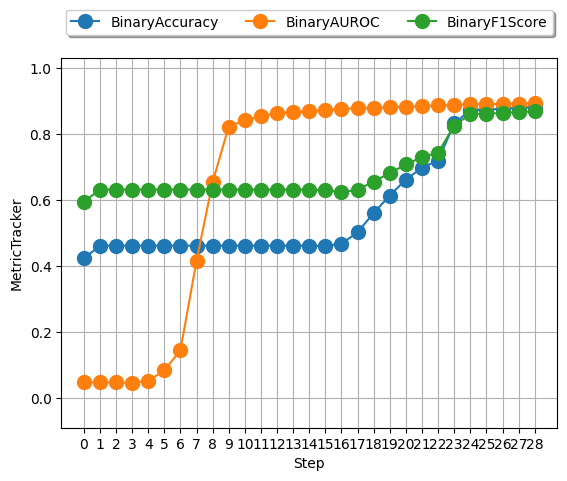

In [8]:
approx_train_tracker.plot()
plt.show()

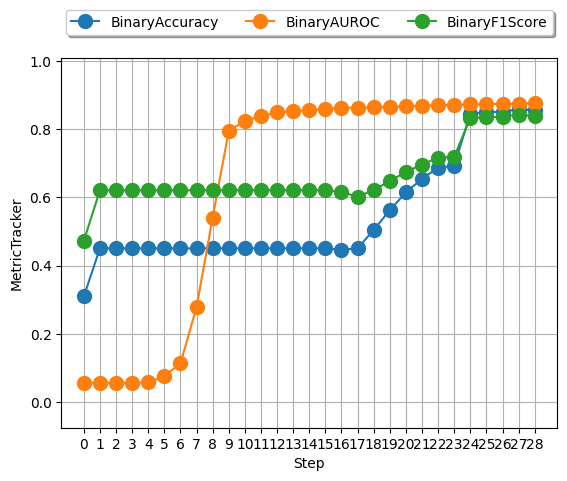

In [9]:
val_tracker.plot()
plt.show()

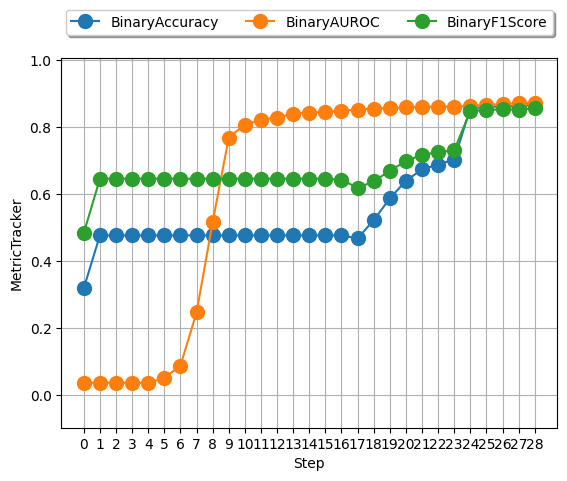

In [10]:
test_tracker.plot()
plt.show()

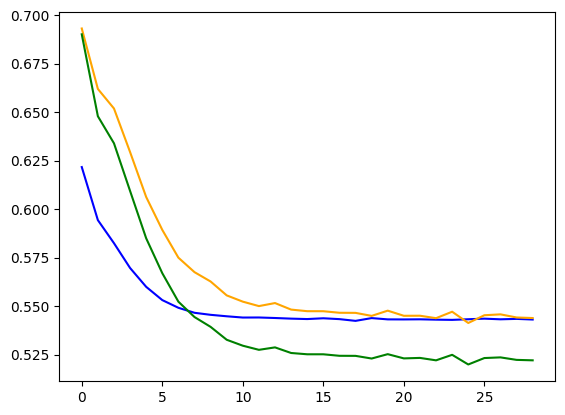

In [33]:
plt.plot(approx_train_losses, color='b')
plt.plot(val_losses, color='orange')
plt.plot(test_losses, color='g')
plt.show()

In [ ]:
test_tracker.plot();
plt.show()

In [23]:
approx_train_tracker.reset_all()
train_tracker.reset_all()
val_tracker.reset_all()
test_tracker.reset_all()